In [2]:
import numpy as np
import tensorflow as tf
import Loader
import Transformer
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.style.use('dark_background')

2022-11-08 22:42:39.155089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 22:42:39.155110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

trainData, testData, valData = Transformer.normalizeData(compoundDataTrain, compoundDataTest, 
                                                         compoundDataValidate, newMean=0, newStd=1)

## SVM for Regression (aka SVR)

Ein Error:  0.3554315298215634
Eval Error:  2.215028122471813


Text(0.5, 1.0, 'Val. Predictions vs Actual')

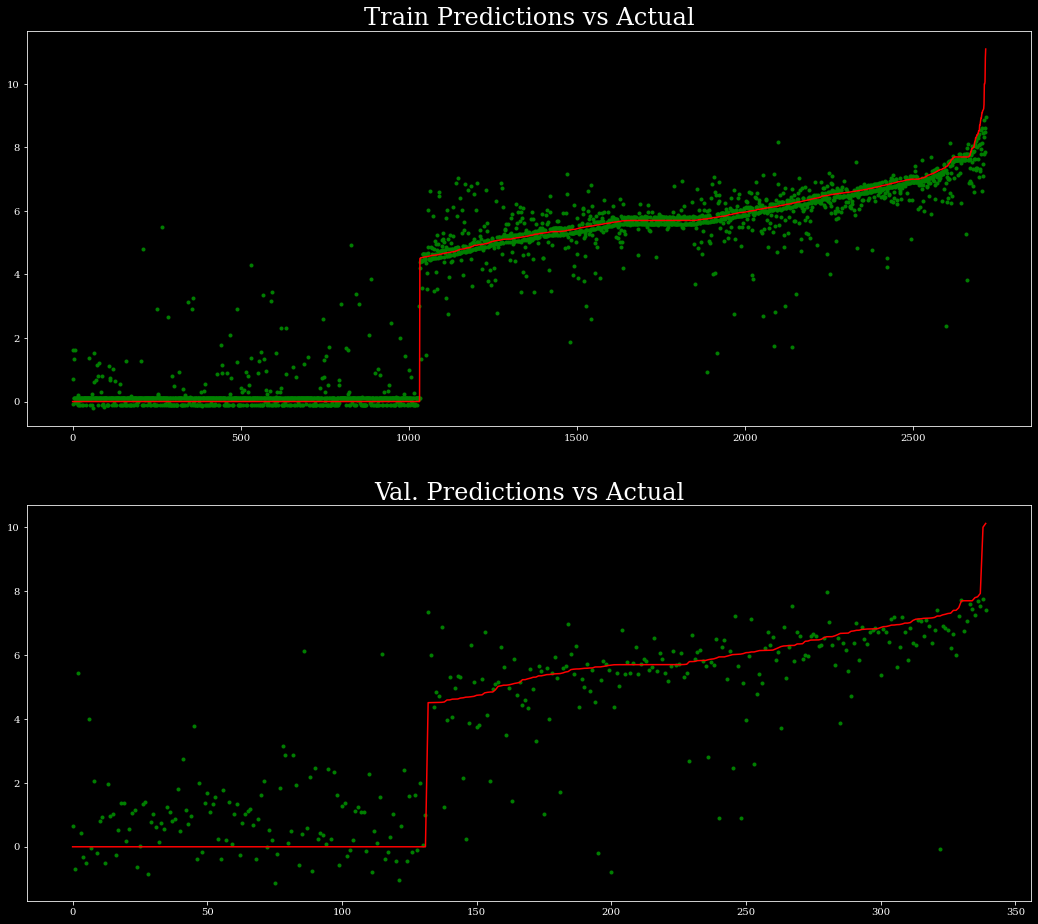

In [4]:
from sklearn import svm
from sklearn.metrics import mean_squared_error

maxC = 10
svrModel = svm.SVR(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    gamma='scale',                  # The kernel coefficient
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
)

svrModel.fit(trainData, activitiesTrain)
trainPred = svrModel.predict(trainData)
valPred = svrModel.predict(valData)
testPred = svrModel.predict(testData)

print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
#print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often


fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], "g.")
ax[0].plot(activitiesTrain[trainOrder], color="red")
ax[1].plot(valPred[valOrder], "g.")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)

## NN Regression

In [30]:
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
inputDim = np.shape(trainData)[1] #how many inputs
#build and run model
    
nnRegrMod = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(350, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(150, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
    ])

nnRegrMod.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

history = nnRegrMod.fit(trainData, activitiesTrain, validation_data = (valData, activitiesValidate), 
    epochs=50, batch_size=10, verbose = 1) #verbose = 0 for no printing

Epoch 1/50
272/272 [==============================] - 2s 7ms/step - loss: 17.0097 - mean_squared_error: 5.1167 - val_loss: 10.2494 - val_mean_squared_error: 2.9312
Epoch 2/50
272/272 [==============================] - 2s 7ms/step - loss: 8.7612 - mean_squared_error: 2.6571 - val_loss: 7.8164 - val_mean_squared_error: 2.6752
Epoch 3/50
272/272 [==============================] - 2s 7ms/step - loss: 6.6510 - mean_squared_error: 2.1749 - val_loss: 7.0584 - val_mean_squared_error: 3.1328
Epoch 4/50
272/272 [==============================] - 2s 7ms/step - loss: 5.4317 - mean_squared_error: 1.9238 - val_loss: 5.2317 - val_mean_squared_error: 2.0856
Epoch 5/50
272/272 [==============================] - 2s 7ms/step - loss: 4.6709 - mean_squared_error: 1.7944 - val_loss: 5.1937 - val_mean_squared_error: 2.5506
Epoch 6/50
272/272 [==============================] - 2s 7ms/step - loss: 4.1082 - mean_squared_error: 1.6467 - val_loss: 4.9195 - val_mean_squared_error: 2.6337
Epoch 7/50
272/272 [======

Text(0.5, 1.0, 'Val. Predictions vs Actual')

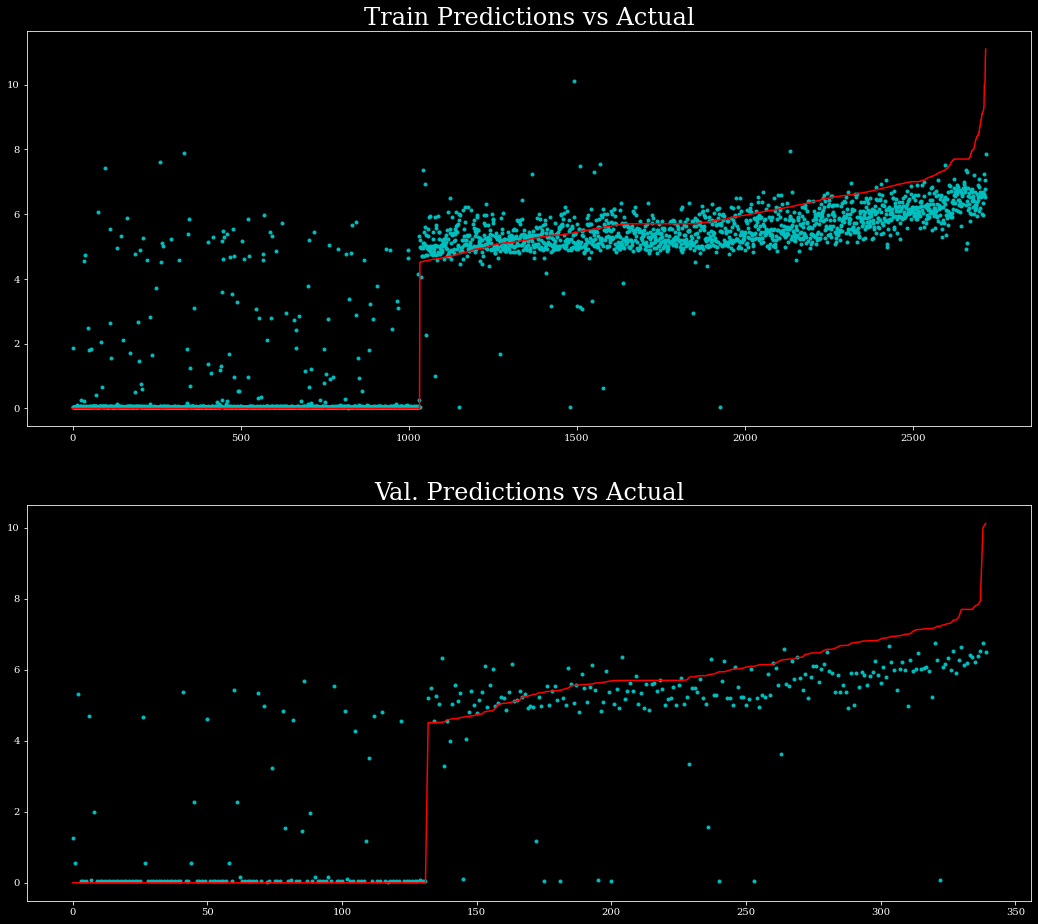

In [7]:
fig, ax = plt.subplots(2, figsize=(18,16))

trainPred = model.predict(trainData).flatten()
valPred = model.predict(valData).flatten()

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], "c.")
ax[0].plot(activitiesTrain[trainOrder], color="red")
ax[1].plot(valPred[valOrder], "c.")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)

## Bah humbug, "mid" performance
New method, use SVM (our best predictor) for classification, then if classified as low activity give it a zero, otherwise use any high activity and then use svm (or more correctly SVR) to classify high activity, should reduce error significantly

In [8]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

trainData, testData, valData = Transformer.normalizeData(compoundDataTrain, compoundDataTest, 
                                                         compoundDataValidate, newMean=0, newStd=1)

trainClass = Transformer.toBinaryClassification(activitiesTrain)
testClass = Transformer.toBinaryClassification(activitiesTest)
valClass = Transformer.toBinaryClassification(activitiesValidate)

In [9]:
#create svm model
from sklearn import svm
from sklearn.metrics import accuracy_score

maxC = 10
binModel =svm.SVC(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
    break_ties=False,               # How to handle breaking ties
)
binModel.fit(trainData, trainClass) #binary classification using svm

highActMask = trainClass == 1 #all the high activity data points

#now run an SVR on the high activity data
maxC = 1
regModel = svm.SVR(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    gamma='scale',                  # The kernel coefficient
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
)
regModel.fit(trainData[highActMask], activitiesTrain[highActMask]); #regression model only on high activity

In [39]:
#alternate regression model
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
inputDim = np.shape(trainData)[1] #how many inputs
#build and run model
    
nnRegr = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(350, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(150, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
    ])

nnRegr.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

highActMask = trainClass == 1 #all the high activity data points

history = nnRegr.fit(trainData[highActMask], activitiesTrain[highActMask], 
    epochs=50, batch_size=5, verbose = 1) #verbose = 0 for no printing

Epoch 1/50
337/337 [==============================] - 3s 6ms/step - loss: 17.8679 - mean_squared_error: 2.2406
Epoch 2/50
337/337 [==============================] - 2s 6ms/step - loss: 9.8294 - mean_squared_error: 0.7809
Epoch 3/50
337/337 [==============================] - 2s 6ms/step - loss: 7.0501 - mean_squared_error: 0.6771
Epoch 4/50
337/337 [==============================] - 2s 6ms/step - loss: 5.1403 - mean_squared_error: 0.5488
Epoch 5/50
337/337 [==============================] - 2s 6ms/step - loss: 3.8206 - mean_squared_error: 0.4954
Epoch 6/50
337/337 [==============================] - 2s 6ms/step - loss: 2.8783 - mean_squared_error: 0.4634
Epoch 7/50
337/337 [==============================] - 2s 6ms/step - loss: 2.2941 - mean_squared_error: 0.5304
Epoch 8/50
337/337 [==============================] - 2s 6ms/step - loss: 1.7657 - mean_squared_error: 0.4575
Epoch 9/50
337/337 [==============================] - 2s 6ms/step - loss: 1.4548 - mean_squared_error: 0.4574
Epoch 10/

In [44]:
def evalData(inputData, svmModel, svrModel, zeroGuess=0): #given the models and data points evaluate
    finalPred = np.ones(len(inputData))*zeroGuess #how many predictions we should have
    binaryClass = svmModel.predict(inputData)
    
    regrPredict = svrModel.predict(inputData[binaryClass == 1]) #regression high activity prediction
    finalPred[binaryClass == 1] = regrPredict #set the high activity guesses, otherwise 0
    return finalPred

def evalData2(inputData, svmModel, nnModel, zeroGuess=0): #same as above but use NN for regr
    finalPred = np.ones(len(inputData))*zeroGuess #how many predictions we should have
    binaryClass = svmModel.predict(inputData)
    
    regrPredict = nnModel.predict(inputData[binaryClass == 1]).flatten() #high activity regr predict
    finalPred[binaryClass == 1] = regrPredict #set the high activity guesses, otherwise 0
    return finalPred
    
zGuess = 0
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess)
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

trainPred2 = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess)
valPred2 = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

print("SVR:")
print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
print('\nNN:')
print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred2))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred2))

#only if we're testing test data
#print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often

SVR:
Ein Error:  0.1838811990198813
Eval Error:  2.377447226475269

NN:
Ein Error:  0.19135124309246326
Eval Error:  2.3724194139174353


In [20]:
print(np.mean(activitiesTrain[activitiesTrain > 4]))

5.99159657462886


## Figure out the best constant guess
Or just use math: https://www.desmos.com/calculator/hz7dfu92wr

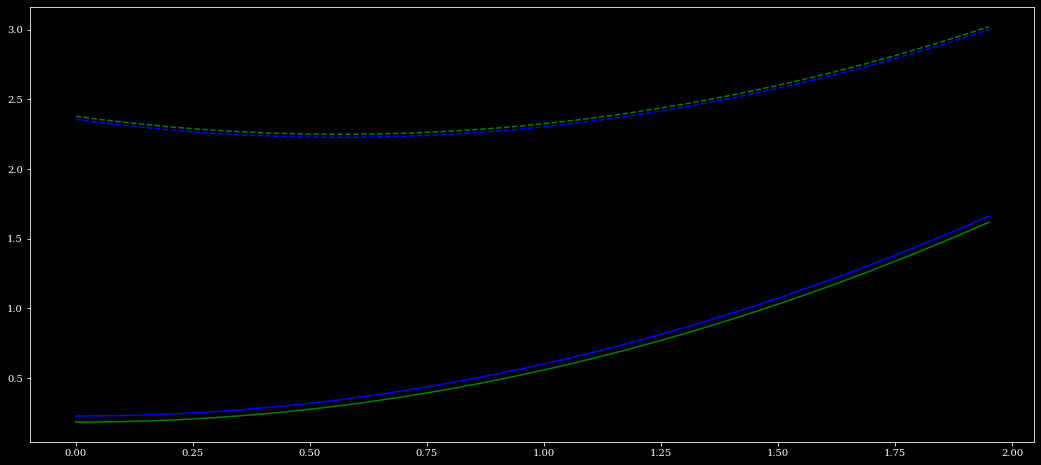

In [13]:
zGuesses = np.arange(0,2,.05)
trainErrorS = [] #SVM regr
valErrorS = [] #SVM regr
trainErrorN = [] #NN regr
valErrorN = [] #NN regr

for zG in zGuesses:
    trainPredS = evalData(trainData, binModel, regModel, zeroGuess=zG)
    valPredS = evalData(valData, binModel, regModel, zeroGuess=zG)
    trainPredN = evalData2(trainData, binModel, nnRegr, zeroGuess=zG)
    valPredN = evalData2(valData, binModel, nnRegr, zeroGuess=zG)
    
    trainErrorS.append(mean_squared_error(activitiesTrain, trainPredS))
    valErrorS.append(mean_squared_error(activitiesValidate, valPredS))
    trainErrorN.append(mean_squared_error(activitiesTrain, trainPredN))
    valErrorN.append(mean_squared_error(activitiesValidate, valPredN))
    
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(zGuesses, trainErrorS, color="green")
ax.plot(zGuesses, valErrorS, color="green", linestyle="dashed")
ax.plot(zGuesses, trainErrorN, color="blue")
ax.plot(zGuesses, valErrorN, color="blue", linestyle="dashed")

## Getting an idea of prediction accuracy

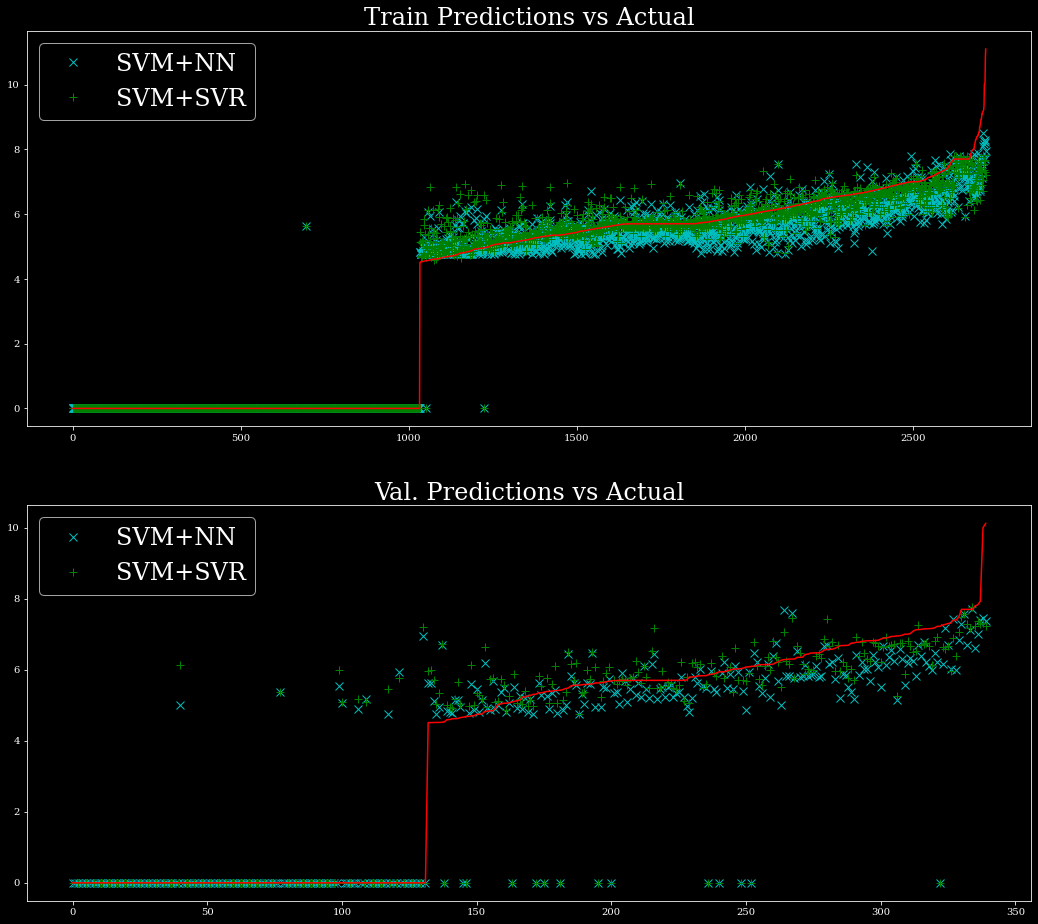

In [37]:
zGuess = 0
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess)
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

trainPred2 = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess)
valPred2 = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred2[trainOrder], "cx", ms=8, label="SVM+NN")
ax[0].plot(trainPred[trainOrder], "g+", ms=8, label="SVM+SVR")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred2[valOrder], "cx", ms=8, label="SVM+NN")
ax[1].plot(valPred[valOrder], "g+", ms=8, label="SVM+SVR")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

## Comparing the two
First SVR vs SVM + SVR
Then NN vs SVM + NN

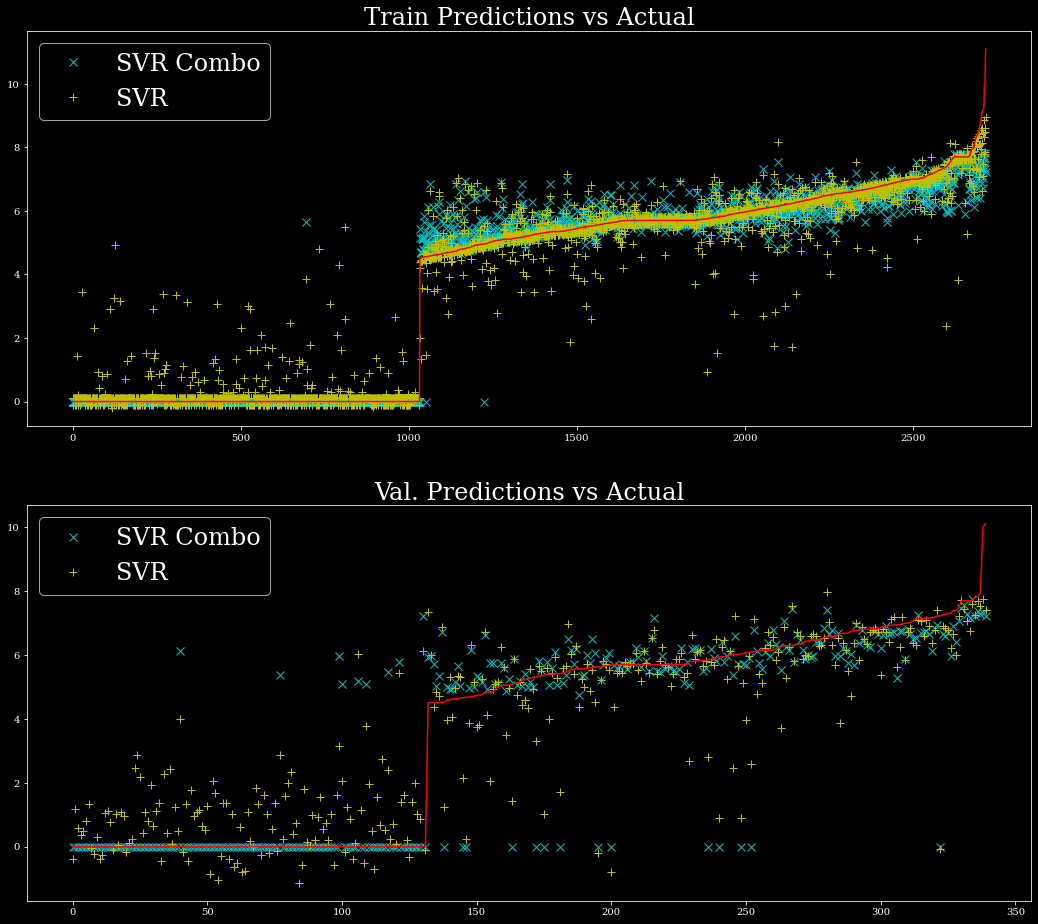

In [47]:
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess) #SVM + SVR
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)

trainPred2 = svrModel.predict(trainData) #Just SVM
valPred2 = svrModel.predict(valData)

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], "cx", ms=8, label="SVR Combo")
ax[0].plot(trainPred2[trainOrder], "y+", ms=8, label="SVR")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred[valOrder], "cx", ms=8, label="SVR Combo")
ax[1].plot(valPred2[valOrder], "y+", ms=8, label="SVR")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

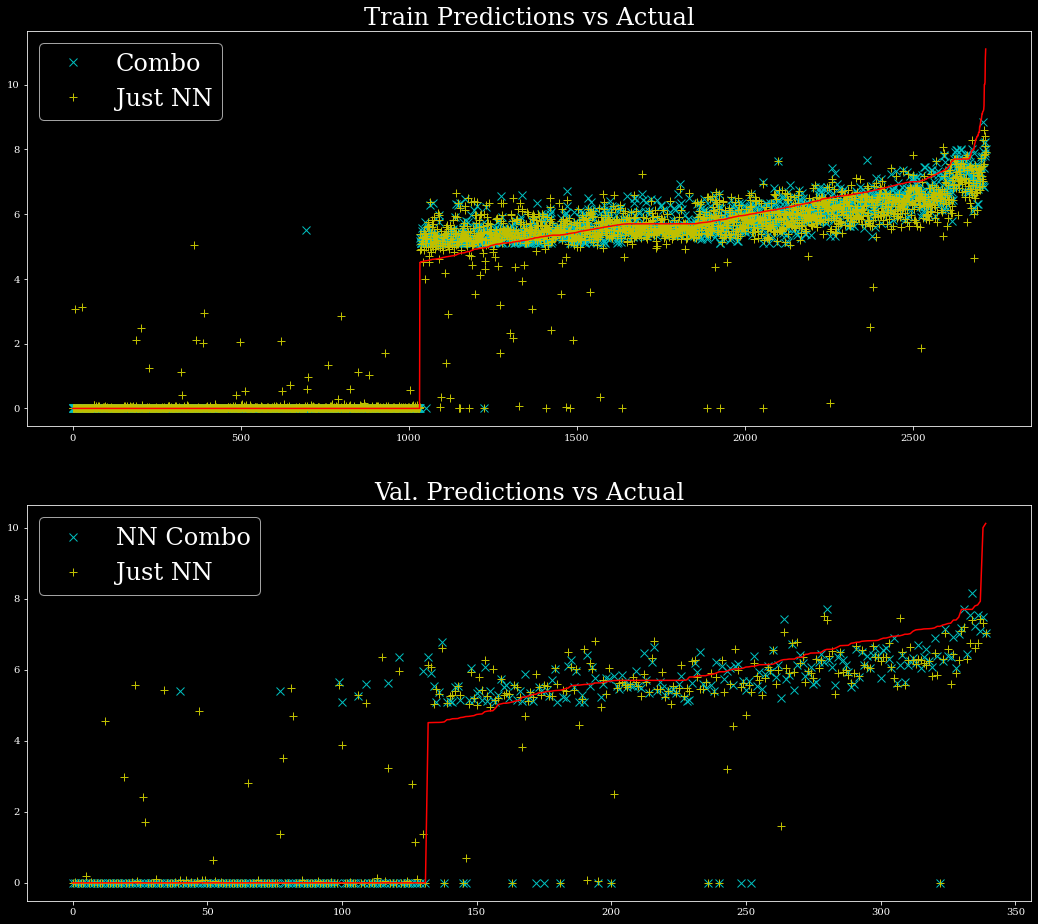

In [45]:
trainPred = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess) #SVM + NN regr
valPred = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)

trainPred2 = nnRegrMod.predict(trainData).flatten() #Just NN
valPred2 = nnRegrMod.predict(valData).flatten()

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], "cx", ms=8, label="Combo")
ax[0].plot(trainPred2[trainOrder], "y+", ms=8, label="Just NN")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred[valOrder], "cx", ms=8, label="NN Combo")
ax[1].plot(valPred2[valOrder], "y+", ms=8, label="Just NN")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

In [52]:
#just github pushing code

!git 
!git commit -m "Regression combination with decent results"

diff --git a/Code/.ipynb_checkpoints/Regression Models (SVM and NN)-checkpoint.ipynb b/Code/.ipynb_checkpoints/Regression Models (SVM and NN)-checkpoint.ipynb
index 503cf21..45f4554 100644
--- a/Code/.ipynb_checkpoints/Regression Models (SVM and NN)-checkpoint.ipynb	
+++ b/Code/.ipynb_checkpoints/Regression Models (SVM and NN)-checkpoint.ipynb	
@@ -2,10 +2,19 @@
  "cells": [
   {
    "cell_type": "code",
-   "execution_count": 8,
+   "execution_count": 2,
    "id": "3417244e",
    "metadata": {},
-   "outputs": [],
+   "outputs": [
+    {
+     "name": "stderr",
+     "output_type": "stream",
+     "text": [
+      "2022-11-08 22:42:39.155089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory\n",
+      "2022-11-08 22:42:39.155110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU 

+      "image/png": "iVBORw0KGgoAAAANSUhEUgAABBEAAAHRCAYAAAA8KyF4AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAABirElEQVR4nO3deZhcZZn38W93ls7W2clGIBASIBAIW5CIhEUUARfAjVERRwZeVF7BmVdlZHBmABkyoo4KImJGncEVUEEisgiExQAdAoGwhJAVstBJOnvSWfv94z4n53Snl+qk9/5+rutcVX2WqtOpJFXnV/dzP0VAFZIkSZIkSQ0obu0TkCRJkiRJ7YMhgiRJkiRJKoghgiRJkiRJKoghgiRJkiRJKoghgiRJkiRJKoghgiRJkiRJKkjX1nri8vJyFi9e3FpPL0mSJEmSajFq1CiGDBlS67ZWCxEWL17MxIkTW+vpJUmSJElSLcrKyurc5nAGSZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUEEMESZIkSZJUkK4N7VBUVMSf/vQnnn32Wbp3784hhxzC5z//eSorK3fvU1JSws0338zSpUsZO3YsN910E/PmzWvWE5ckSZIkqc0pAQ4FxgHdgTtb93SaWkGVCDNmzOD666/n2muvpVevXlxwwQXVtl911VUsWbKEm266ie9973tMnTq1WU5WkiRJkqQ2pwfQJbn/buCjwAHAaqCotU6qeTRYiVBVVcW3vvUtALp06cLIkSOZO3dutX3OPfdcvvGNbwAwZ84cJkyYQGlpKRs2bGiGU5YkSZIkqZX1Ag4HjgA

diff --git a/Code/Regression Models (SVM and NN).ipynb b/Code/Regression Models (SVM and NN).ipynb
index 55efecd..6d815e1 100644
--- a/Code/Regression Models (SVM and NN).ipynb	
+++ b/Code/Regression Models (SVM and NN).ipynb	
@@ -2,10 +2,19 @@
  "cells": [
   {
    "cell_type": "code",
-   "execution_count": 8,
+   "execution_count": 2,
    "id": "3417244e",
    "metadata": {},
-   "outputs": [],
+   "outputs": [
+    {
+     "name": "stderr",
+     "output_type": "stream",
+     "text": [
+      "2022-11-08 22:42:39.155089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory\n",
+      "2022-11-08 22:42:39.155110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.\n"
+     ]
+    }
+   ],
    "source": [
     "import numpy as np\n",
     "import tensorflow as

-      "image/png": "iVBORw0KGgoAAAANSUhEUgAABA4AAAOECAYAAAAhUnNwAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdeZwbdf348Vd2t9v7oC0tFGhLoS1HuSmC3AJfRNCvgvrFA2/wQkFR8RYRFQVUvLWiiIoih9ePS5GjUAuUW45S6E3pXXrQe3fz+2NmNpNkJsmeSXdfz8ejTTKZzHySTLL5vOf9eX8yQBZJkiRJkqQEddVugCRJkiRJql0GDiRJkiRJUioDB5IkSZIkKZWBA0mSJEmSlMrAgSRJkiRJSmXgQJIkSZIkpWrozp2tWLGChQsXducuJUmSJElSGePGjWPUqFGJ93Vr4GDhwoVMnTq1O3cpSZIkSZLKmDVrVup9DlWQJEmSJEmpDBxIkiRJkqRUBg4kSZIkSVIqAweSJEmSJCmVgQNJkiRJkpTKwIEkSZIkSUpl4ECSJEmSJKUycCBJkiRJklIZOJAkSZIkSakMHEiSJEmSpFQGDiRJkiRJUioDB5IkSZIkKZWBA0mSJEmSlMrAgSRJkiRJSmXgQJIkSZIkpTJwIEmSJElSJ/krcH61G9HJDBxIkiRJktRJTgLGV7sRnczAgSRJkiRJnWQAsKnajehkBg4kSZIkSeoEjQSdbAMHkiRJkiSpyIDwcnNVW9H5DBxIkiRJktQJosCBGQeSJEmSJKlI//DSwIEkSZIkSSriUAVJkiRJkpTKoQqSJEmSJClVNFTBjANJkiRJklSkMbzcVtVWdD4DB5IkSZIkdYKG8LKpqq3ofAYOJEmSJEnqBPXhZXNVW9H5DBxIkiRJktQJzDiQJEmSJEmpoowDAweSJEmSJKlIlHHgUAVJkiRJklTEjANJkiRJkpTKjANJkiRJkpT

diff --git a/Code/Testing running on server.ipynb b/Code/Testing running on server.ipynb
index bf34b66..1504f38 100644
--- a/Code/Testing running on server.ipynb	
+++ b/Code/Testing running on server.ipynb	
@@ -1282,7 +1282,7 @@
    "name": "python",
    "nbconvert_exporter": "python",
    "pygments_lexer": "ipython3",
-   "version": "3.8.3"
+   "version": "3.9.7"
   }
  },
  "nbformat": 4,
